# Plotting WOfS data across Africa with country-boundary shapefile

This plot compares surface water detected by Water Observations from Space between two chosen years. 

**Caveats**

* This uses the WOfS annual summaries, it does not specify differences caused by longer-term trend conditions (such as drought), which should be investigated at a regional scale
* In this notebook, the default resolution is 1km, which makes for easier data processing and computation (no. of pixels equivalent to square kilometre area). This resolution and the resampling technique can be changed or specified in the `dc.load` statement. The default resampling, which is used here, is `nearest`.

## Load packages, connect to datacube

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import geopandas as gpd
from datacube.utils import geometry
import pandas as pd
import matplotlib as mpl

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import rgb, map_shapefile
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.classification import HiddenPrints

dc = datacube.Datacube(app="WOfS-figure")

import warnings
warnings.filterwarnings("ignore", message="Iteration over multi-part geometries is deprecated and will be removed in ")

## 1 - Processing WOfS per country
The final step of this section outputs a new shapefile specific to the data parameters and time periods identified. Once you have generated the shapefile, you can run **2 - Plot WOfS with country boundaries** without repeating this section.

Country boundary shapefile sourced from [openAFRICA](https://open.africa/dataset/africa-shapefiles), with the file last updated on April 21, 2020.

### Load shapefile

In [2]:
vector_file = "Plot_WOfS_by_country-data/african_countries.shp"
gdf = gpd.read_file(vector_file)

In [3]:
gdf.head()

,name,geometry
0,Sudan,"MULTIPOLYGON (((38.58148 18.02542, 38.58203 18..."
1,Angola,"MULTIPOLYGON (((11.79481 -16.81925, 11.79375 -..."
2,Benin,"MULTIPOLYGON (((1.86343 6.28872, 1.86292 6.288..."
3,Botswana,"POLYGON ((25.17447 -17.77881, 25.18476 -17.783..."
4,Burkina Faso,"POLYGON ((-0.45567 15.08082, -0.45411 15.07937..."


<AxesSubplot:>

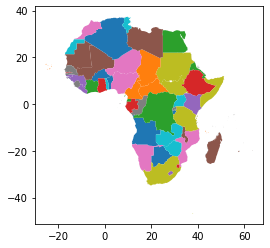

In [4]:
gdf.plot(column='name')

### Analysis parameters

In [5]:
# Set the year you want to compare
year = '2020'

# Set the threshold of water we want to consider water
lower = 0.75
upper = 1.0

In [6]:
attribute_col = 'name'

# products = ['wofs_ls_summary_annual']
measurements = ['frequency']
resolution = (-1000, 1000) 
output_crs = 'EPSG:6933'

In [7]:
query = {'measurements': measurements,
         'resolution': resolution,
         'output_crs': output_crs,
         }

### Define function to calculate surface water per polygon
`gdf.iloc[0:5].iterrows():` can be used to test a smaller number of polygons first.

Arguments:
* `gdf` the geodataframe of the country boundary shapefile
* `year` the designated year to investigate
* `lower` frequency (0-1) lower bound for water (anything above this is included)
* `upper` frequency upper bound (anything above this is excluded) - max value of `1.0`

In [8]:
def water_pixels_per_polygon(gdf, year, lower, upper):
    num_pixels_year = {}
    num_pixels_alltime = {}
    
    # A progress indicator
    i = 0

    # Loop through polygons in geodataframe and extract satellite data
    for index, row in gdf.iterrows():

        print(" Feature {:02}/{:02}\r".format(i + 1, len(gdf)),
                      end='')

        # Get the geometry
        geom = geometry.Geometry(row.geometry.__geo_interface__,
                                 geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))

        # Update dc query with geometry      
        query.update({'geopolygon': geom}) 

        # Load landsat (hide print statements)
        with HiddenPrints():
            ds = dc.load(product=['wofs_ls_summary_annual'],
                         time= year,
                         group_by='solar_day',
                         **query)
            ds_alltime = dc.load(product=['wofs_ls_summary_alltime'],
                         group_by='solar_day',
                         **query)

        # Generate a polygon mask to keep only data within the polygon
        with HiddenPrints():
            mask = xr_rasterize(gdf.iloc[[index]], ds)
            mask_alltime = xr_rasterize(gdf.iloc[[index]], ds_alltime)

        # Mask dataset to set pixels outside the polygon to `NaN`
        ds = ds.where(mask)
        ds_alltime = ds_alltime.where(mask_alltime)

        # Threshold WOfS frequency and append results to dictionary
        if int(upper) == 1:
            num_pixels_year.update({str(row[attribute_col]) : int(ds.frequency.where(ds.frequency > lower).count().values)})
            num_pixels_alltime.update({str(row[attribute_col]) : int(ds_alltime.frequency.where(ds_alltime.frequency > lower).count().values)})
        else:
            num_pixels_year.update({str(row[attribute_col]) : int(ds.frequency.where((ds.frequency > lower) & (ds.frequency < upper)).count().values)})
            num_pixels_alltime.update({str(row[attribute_col]) : int(ds_alltime.frequency.where((ds_alltime.frequency > lower) & (ds_alltime.frequency < upper)).count().values)})
                

        # Update counter
        i += 1
        
    return num_pixels_year, num_pixels_alltime

~~We run this function twice; once each for each of the years to be compared. This process can take a while and is sped up with a higher-core instance.~~
We run this once to generate two dictionaries, one for the specified year, and one for all-time.

In [9]:
num_pixels_year, num_pixels_alltime = water_pixels_per_polygon(gdf, year, lower, upper)

In [10]:
num_pixels_year

{'Sudan': 2085,
 'Angola': 512,
 'Benin': 94,
 'Botswana': 56,
 'Burkina Faso': 365,
 'Cameroon': 1242,
 'Cape Verde': 28,
 'Central African Republic': 74,
 'Chad': 1292,
 'Comoros': 1,
 'Republic of the Congo': 647,
 "Cote d'Ivoire": 1342,
 'Democratic Republic of the Congo': 27594,
 'Djibouti': 102,
 'South Sudan': 208,
 'Equatorial Guinea': 61,
 'Eritrea': 248,
 'Ethiopia': 6845,
 'Gabon': 946,
 'Gambia': 581,
 'Ghana': 5911,
 'Guinea-Bissau': 87,
 'Guinea': 71,
 'Kenya': 11314,
 'Lesotho': 0,
 'Liberia': 165,
 'Madagascar': 942,
 'Malawi': 22859,
 'Mali': 727,
 'Mauritania': 199,
 'Mauritius': 3,
 'Mozambique': 9568,
 'Namibia': 109,
 'Niger': 132,
 'Nigeria': 2967,
 'Senegal': 831,
 'Seychelles': 28,
 'Sierra Leone': 96,
 'Somalia': 266,
 'South Africa': 1371,
 'Burundi': 1846,
 'Eswatini': 14,
 'Togo': 88,
 'Uganda': 34701,
 'Tanzania': 58847,
 'Zambia': 10400,
 'Zimbabwe': 2477,
 'Algeria': 167,
 'Libya': 200,
 'Morocco': 205,
 'Rwanda': 1156,
 'Sao Tome and Principe': 1,
 'Tuni

In [11]:
num_pixels_alltime

{'Sudan': 1392,
 'Angola': 299,
 'Benin': 99,
 'Botswana': 55,
 'Burkina Faso': 176,
 'Cameroon': 1120,
 'Cape Verde': 95,
 'Central African Republic': 66,
 'Chad': 1107,
 'Comoros': 5,
 'Republic of the Congo': 603,
 "Cote d'Ivoire": 1316,
 'Democratic Republic of the Congo': 28021,
 'Djibouti': 105,
 'South Sudan': 142,
 'Equatorial Guinea': 67,
 'Eritrea': 223,
 'Ethiopia': 6057,
 'Gabon': 947,
 'Gambia': 584,
 'Ghana': 4923,
 'Guinea-Bissau': 86,
 'Guinea': 69,
 'Kenya': 10895,
 'Lesotho': 0,
 'Liberia': 163,
 'Madagascar': 1010,
 'Malawi': 23145,
 'Mali': 583,
 'Mauritania': 180,
 'Mauritius': 8,
 'Mozambique': 9324,
 'Namibia': 112,
 'Niger': 4,
 'Nigeria': 2610,
 'Senegal': 851,
 'Seychelles': 36,
 'Sierra Leone': 98,
 'Somalia': 144,
 'South Africa': 1247,
 'Burundi': 1843,
 'Eswatini': 9,
 'Togo': 89,
 'Uganda': 34672,
 'Tanzania': 54577,
 'Zambia': 10126,
 'Zimbabwe': 2525,
 'Algeria': 118,
 'Libya': 239,
 'Morocco': 179,
 'Rwanda': 1144,
 'Sao Tome and Principe': 3,
 'Tunisi

### Append the new data and export dataframe

In [12]:
pdpixel_all = pd.Series(num_pixels_alltime)
pdpixel_year = pd.Series(num_pixels_year)

# Calculate the difference between the current and past years
pdpixel_diff = pdpixel_year - pdpixel_all

In [13]:
# Add to the geodataframe
gdf = gdf.assign(px_all=pdpixel_all.values)
gdf = gdf.assign(px_year=pdpixel_year.values)
gdf = gdf.assign(px_diff=pdpixel_diff.values)

In [14]:
# Calculate percentage change (pc_change)
pc_change = (gdf.px_diff/gdf.px_all*100).fillna(0)

# Add to the geodataframe
gdf = gdf.assign(pc_change=pc_change.values)

### Export new shapefile with % change data

In [18]:
gdf.to_file("Plot_WOfS_by_country-data/wofs_pc_change_"+year+"_vs_alltime_"+str(int(lower*100))+"-"+str(int(upper*100))+".shp")

## 2 - Plot WOfS with country boundaries

If you have successfully exported the previous shapefile but started a new instance, there is no need to re-process the data. It can be read in from the shapefile by uncommenting and running the code below. Be sure the vector file path is to the correct shapefile title.

In [16]:
# vector_file = "Plot_WOfS_by_country-data/wofs_pc_change_2020_vs_alltime_60-100.shp"
# gdf = gpd.read_file(vector_file)

In [17]:
gdf.head()

,name,geometry,px_all,px_year,px_diff,pc_change
0,Sudan,"MULTIPOLYGON (((38.58148 18.02542, 38.58203 18...",1392,2085,693,49.784483
1,Angola,"MULTIPOLYGON (((11.79481 -16.81925, 11.79375 -...",299,512,213,71.237458
2,Benin,"MULTIPOLYGON (((1.86343 6.28872, 1.86292 6.288...",99,94,-5,-5.050505
3,Botswana,"POLYGON ((25.17447 -17.77881, 25.18476 -17.783...",55,56,1,1.818182
4,Burkina Faso,"POLYGON ((-0.45567 15.08082, -0.45411 15.07937...",176,365,189,107.386364


### Customise the plot

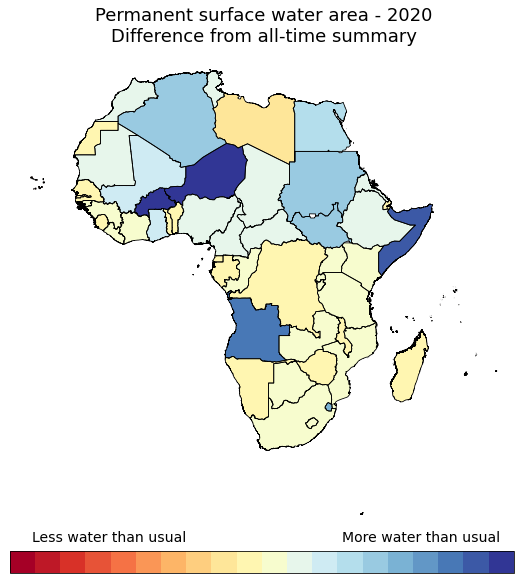

In [20]:
# Define plot and colourbar axes
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.subplots_adjust(bottom=0.2)
cax = fig.add_axes([0.16, 0.15, 0.70, 0.03])

# Define colour map
cmap = mpl.cm.RdYlBu
bounds = list(range(-100, 101, 10))
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)#, extend='both')
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

# Define colourbar labelling
cbar.set_ticks([]) #list(range(-100, 101, 25)))
# cbar.set_ticklabels(list('{:2}%'.format(i) for i in (list(range(-100, 101, 25)))))
# cbar.set_label("% change", fontsize='14')

# Turn off lon-lat ticks and labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

# Remove frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plot 'pc_change' and 'geometry' boundary lines
gdf.plot('pc_change', ax=ax, cmap=cmap, vmin=-100, vmax=100, norm=norm)
gdf.geometry.plot(ax=ax, linewidth=0.8, edgecolor='black', facecolor="none")

# Additional text boxes
ax.text(-25, -52, s="Less water than usual", color='black', fontsize='14')
ax.text(34, -52, s="More water than usual", color='black', fontsize='14')

# Plot title
ax.set_title("Permanent surface water area - "+year+"\nDifference from all-time summary", fontsize='18')

# Export figure
fig.savefig('wofs_pc_change_'+year+'_vs_alltime_'+str(int(lower*100))+'-'+str(int(upper*100))+'.png', 
            bbox_inches='tight',
            dpi=200, 
            facecolor="white")

## 3 - Check rainfall for the given year

## 4 - Investigate a single country

Use this section to do any of the following
* plot a single country of data
* verify the function defined in (1) 
* check the effects of a boundary buffer on the results

In [12]:
# import the original country shapefile
vector_file = "african_countries.shp"
gdf = gpd.read_file(vector_file)

In [13]:
gdf.head()

,name,geometry
0,Sudan,"MULTIPOLYGON (((38.58148 18.02542, 38.58203 18..."
1,Angola,"MULTIPOLYGON (((11.79481 -16.81925, 11.79375 -..."
2,Benin,"MULTIPOLYGON (((1.86343 6.28872, 1.86292 6.288..."
3,Botswana,"POLYGON ((25.17447 -17.77881, 25.18476 -17.783..."
4,Burkina Faso,"POLYGON ((-0.45567 15.08082, -0.45411 15.07937..."


In [14]:
gdf_somalia = gdf.loc[gdf['name'] == 'Somalia'] 

In [15]:
gdf_somalia

,name,geometry
38,Somalia,"MULTIPOLYGON (((41.57762 -1.66024, 41.57721 -1..."


In [16]:
# If you want to check the results of a buffer
# buffer value is defined in the same units as the CRS

# gdf_somalia['geometry'] = gdf_somalia.geometry.buffer(-0.005)
# gdf_somalia

In [17]:
geom = geometry.Geometry(gdf_somalia.unary_union, gdf_somalia.crs)
geom

query = {'measurements': measurements,
         'resolution': resolution,
         'output_crs': output_crs,
         }

In [18]:
#load wofs alltime
ds_alltime = dc.load(product='wofs_ls_summary_alltime',
                     geopolygon = geom,
                     **query)

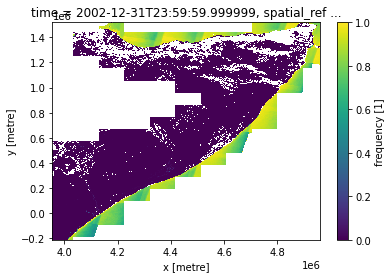

In [19]:
ds_alltime.frequency.plot()

In [ ]:
ds = dc.load(product="wofs_ls_summary_annual",
                  time=('2020'),
                  resampling='nearest',
                  like=ds_alltime.geobox
                  ).frequency

In [ ]:
ds.plot()

### Mask NaNs

In [ ]:
mask = xr_rasterize(gdf_somalia, ds)

In [ ]:
ds = ds.where(mask)

In [ ]:
ds.plot()

In [ ]:
ds.count()

In [ ]:
mask_alltime = xr_rasterize(gdf_somalia, ds_alltime)

In [ ]:
ds_alltime = ds_alltime.where(mask)

In [ ]:
ds_alltime.frequency.plot()

In [ ]:
ds_alltime.frequency.count()

### Check number of thresholded values and compare to the original (unbuffered) function

In [ ]:
alltime_water = ds_alltime.frequency.where(ds_alltime.frequency > 0.6)
alltime_water.count()

In [ ]:
ds_water = ds.where(ds > 0.6)
ds_water.count()

In [ ]:
ds_water.plot()

In [ ]:
alltime_water.plot()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')